# imports y funciones

In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 35.4 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [40]:
import pandas as pd
# import statsmodels.graphics.tsaplots as sgt 
# import statsmodels.tsa.stattools as sts
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.seasonal import seasonal_decompose
import zipfile
import requests
import io
import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns
from pmdarima.arima import auto_arima
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
# import time
from datetime import timedelta
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pickle
import warnings
warnings.filterwarnings("ignore")



In [3]:
FILE_NAME_CSV_DATASET_CLIMA = 'https://raw.githubusercontent.com/PabloSGomez50/humai-solar-panels/main/scraper_clima/clima_sydney_limpio3.csv'
FILE_NAME_CSV_DATASET_PRODUCCION = 'https://github.com/PabloSGomez50/humai-solar-panels/blob/main/script_produccion/produccion.csv.zip?raw=true'
                                    

In [74]:
def get_dataset_clima():
  df_clima = pd.read_csv(FILE_NAME_CSV_DATASET_CLIMA)
  df_clima.drop(columns=['Unnamed: 0'], inplace = True)
  df_clima.rename(columns={'Date': 'Datetime'}, inplace = True)    

  # elimino dos registros que estaban duplicados
  dupli_1_index = df_clima[(df_clima.Datetime == '2013-04-07 02:00:00') & (df_clima.Barometer == 1023)].index
  dupli_2_index = df_clima[(df_clima.Datetime == '2013-04-07 02:30:00') & (df_clima.Barometer == 1023)].index
  df_clima = df_clima.drop(df_clima.index[dupli_1_index]).drop(df_clima.index[dupli_2_index]) 

  df_clima['Datetime'] = pd.to_datetime(df_clima['Datetime'], format='%Y-%m-%d %H:%M:%S')
  df_clima['Hora'] = df_clima.Datetime.dt.hour    
  df_clima['Mes'] = df_clima.Datetime.dt.month


  return df_clima

def get_dataset_produccion():
  content = requests.get(FILE_NAME_CSV_DATASET_PRODUCCION).content
  zip_file = zipfile.ZipFile(io.BytesIO(content))
  file = zip_file.open("produccion.csv")
  df_produccion = pd.read_csv(file)
  df_produccion.rename(columns={'datetime': 'Datetime'}, inplace = True)
  df_produccion['Datetime'] = pd.to_datetime(df_produccion['Datetime'], format='%Y-%m-%d %H:%M:%S')

  return df_produccion

def join_dataset(df_clima, df_produccion, customer_id):

  # me quedo con un unico customer_id
  df_produccion_only_one_customer = df_produccion[df_produccion.Customer == customer_id]
  df_produccion_only_one_customer.drop(columns='Customer', inplace = True)

  # luego de este join van a aparecer muchos registros con los datos del clima en NaN
  df_join = df_produccion_only_one_customer.merge(df_clima, left_on="Datetime", right_on="Datetime", how="left")

  # casteo la fecha para que sea datatime
  df_join['Datetime'] = pd.to_datetime(df_join['Datetime'], format='%Y-%m-%d %H:%M:%S')

  # Ordeno el dataset para que la imputacion por el valor anterior funcione correctamente
  df_join.sort_values(by ='Datetime', inplace=True)
  df_join.fillna(method = 'ffill', inplace = True)

  df_join['Hora'] = df_join['Hora'].astype(int)
  df_join['Mes'] = df_join['Mes'].astype(int)
  df_join['Temp'] = df_join['Temp'].astype(int)
  df_join['Wind'] = df_join['Wind'].astype(int)
  df_join['Humidity'] = df_join['Humidity'].astype(int)
  df_join['Barometer'] = df_join['Barometer'].astype(int)
  df_join['Visibility'] = df_join['Visibility'].astype(int)

  columns_rename = {
      'Temp': 'Temperatura',
      'Weather': 'Clima',
      'Wind': 'Viento',
      'Humidity': 'Humedad',
      'Barometer': 'Presion_atmosferica',
      'Visibility': 'Visibilidad',
      'Partly sunny': 'Partly_sunny',
      'Passing clouds': 'Passing_clouds',
      'Scattered clouds': 'Scattered_clouds'
  }

  df_join.rename(columns=columns_rename, inplace = True)    


  # Seteo la fecha como index y establezco la frecuencia    
  df_join.set_index("Datetime", inplace=True)
  df_join = df_join.asfreq('30T')

  return df_join

def resample_dataset(df):
  resample = df.resample(rule="1H")
  join_resaple = resample['Produccion'].sum()
  df_resample = pd.DataFrame(join_resaple)
  df_resample['Temperatura'] = resample['Temperatura'].mean()
  df_resample['Viento'] = resample['Viento'].mean()
  df_resample['Humedad'] = resample['Humedad'].mean()
  df_resample['Presion_atmosferica'] = resample['Presion_atmosferica'].mean()
  df_resample['Visibilidad'] = resample['Visibilidad'].mean()
  df_resample['Clear'] = resample['Clear'].first()
  df_resample['Partly_sunny'] = resample['Partly_sunny'].first()
  df_resample['Passing_clouds'] = resample['Passing_clouds'].first()
  df_resample['Scattered_clouds'] = resample['Scattered_clouds'].first()
  df_resample['Sunny'] = resample['Sunny'].first()
  df_resample['Clima'] = resample['Clima'].first()
  df_resample['Hora'] = resample['Hora'].first()
  df_resample['Mes'] = resample['Mes'].first()
  df_resample = df_resample.asfreq('1H')
  return df_resample


  
def predict_plot(model, df_train, df_test, periods_before, periods_predict, columns_exog = None):
  date_from = df_test.reset_index()["Datetime"].min()
  date_to = date_from + timedelta(hours=periods_predict)


  # Obtener la predicción y los intervalos de confianza
  if columns_exog is None:
    preds = model.get_prediction(start=date_from, end=date_to, dynamic=False)
  else:
    preds = model.get_prediction(start=date_from, end=date_to, dynamic=False, exog=df_test.loc[date_from:date_to][columns_exog])
  pred_conf = preds.conf_int(alpha=0.9)

  # Graficar los datos de entrenamiento, prueba y predicción, y las bandas de confianza
  plt.figure(figsize=(20, 10))
  plt.plot(df_train['Produccion'][-periods_before:], label='Train', color='blue')
  plt.plot(df_test['Produccion'][:periods_predict], label='Test', color='blue', linestyle='--')
  plt.plot(preds.predicted_mean, label='Forecast', color='magenta')
  plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='gray', alpha=0.6)
  plt.legend(loc='upper left')
  plt.show()

def RMSE(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

def get_RMSE (model, df_test, periods_predict, columns_exog = None):

  date_from = df_test.reset_index()["Datetime"].min()
  date_to = date_from + timedelta(hours=periods_predict)

  if columns_exog is None:
    predicted = model.get_prediction(start=date_from, end=date_to, dynamic=False)
  else:
    predicted = model.get_prediction(start=date_from, end=date_to, dynamic=False, exog=df_test.loc[date_from:date_to][columns_exog])
  
  actual = df_test.loc[date_from:date_to].Produccion

  mse = (predicted.predicted_mean - actual)**2
  rmse = np.sqrt(mse.sum()/mse.count())
  return rmse    


dfModelsResults = pd.DataFrame(columns = ["Model", "RMSE Train", "RMSE Test"])

def put_model_result(model_name, rmse_train, rmse_test):

  if dfModelsResults[dfModelsResults.Model == model_name].shape[0] == 1:  
    index = dfModelsResults[dfModelsResults.Model == model_name].index.values.tolist()[0]
  else:
    index = dfModelsResults.shape[0]
  dfModelsResults.loc[index,"Model"] = model_name
  dfModelsResults.loc[index,"RMSE Train"] = rmse_train
  dfModelsResults.loc[index,"RMSE Test"] = rmse_test
  #dfModelsResults.loc[index,"RMSE val"] = rmse_val

  return dfModelsResults  

In [5]:
df_clima = get_dataset_clima()
df_produccion = get_dataset_produccion()
Customer_id = 12
df_join = join_dataset(df_clima, df_produccion, Customer_id)
df_join = resample_dataset(df_join)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# Modelos

Separo mi conjunto de datos en train y test

In [6]:
# Agrego una columna que le de un orden a los registros comenzando por 0 e incrementandose de 1 en 1
df_join["timeIndex"] = df_join.index - df_join.index.min()
df_join["timeIndex"] =  df_join["timeIndex"]/np.timedelta64(60, 'm')
df_join["timeIndex"] = df_join["timeIndex"].round(0).astype(int)

# guardo 1 semana de datos para testear
split = len(df_join) - (24 * 7 * 8)
df_train = df_join[:split]
df_test = df_join[split:]

#hago otro split para train, test y validacion
df_train_24 = df_train
split_validation = len(df_test) - (24 * 7 * 4)
df_test_24 = df_test[:split_validation]
df_validation_24 = df_test[split_validation:]

print(df_train.tail(2).index)
print(df_test.head(2).index)

DatetimeIndex(['2013-05-05 22:00:00', '2013-05-05 23:00:00'], dtype='datetime64[ns]', name='Datetime', freq='H')
DatetimeIndex(['2013-05-06 00:00:00', '2013-05-06 01:00:00'], dtype='datetime64[ns]', name='Datetime', freq='H')


## Media constante

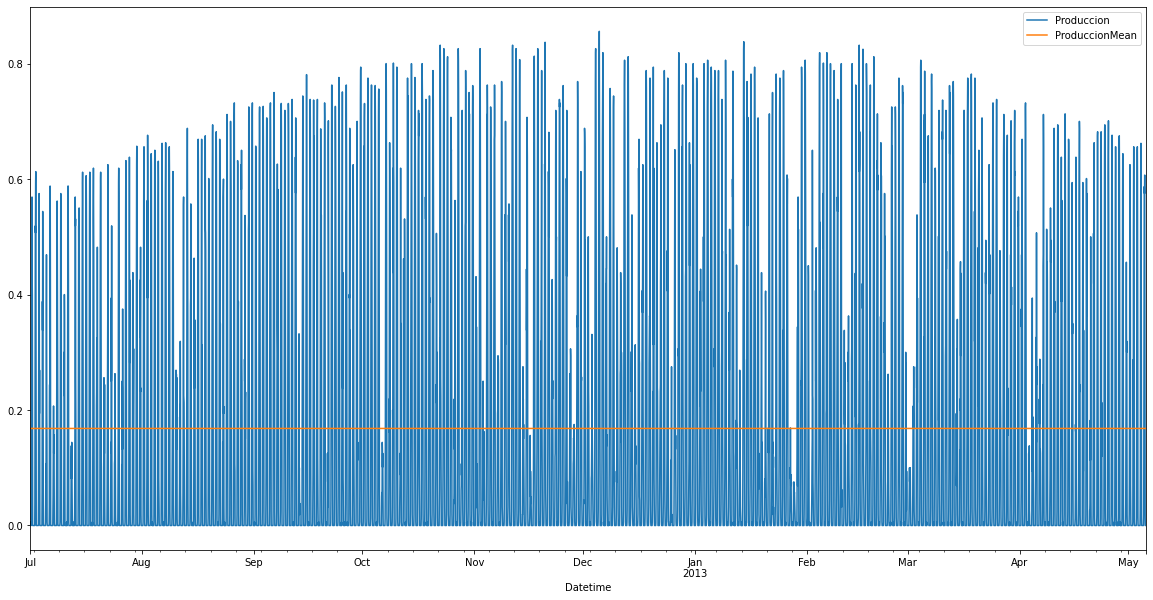

In [76]:
model_mean_pred = df_train.Produccion.mean()

df_train["ProduccionMean"] = model_mean_pred
df_test["ProduccionMean"] = model_mean_pred

df_train.plot(kind="line", y = ["Produccion", "ProduccionMean"], figsize=(20,10));

Guardo el resultado en una tabla para luego hacer una comparacion entre los modelos.

In [77]:
put_model_result(
    "Media constante", 
    RMSE(df_train.ProduccionMean, df_train.Produccion), 
    RMSE(df_test.ProduccionMean, df_test.Produccion)
  )

,Model,RMSE Train,RMSE Test
0,Media constante,0.243035,0.18775


## Regresion Lineal

In [78]:
model_linear = smf.ols('Produccion ~ timeIndex', data = df_train).fit()
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Produccion   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.243
Date:                Thu, 23 Feb 2023   Prob (F-statistic):             0.0394
Time:                        17:19:59   Log-Likelihood:                -30.428
No. Observations:                7416   AIC:                             64.86
Df Residuals:                    7414   BIC:                             78.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1580      0.006     28.006      0.000       0.147       0.169
timeIndex   2.715e-06   1.32e-06      2.060      0.039    1.31e-07     5.3e-06
==============================================================================
Omnibus:                     1202.617   Durbin-Watson:                   0.175
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1901.541
Skew:                           1.239   Prob(JB):                         0.00
Kurtosis:                       3.113   Cond. No.                     8.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

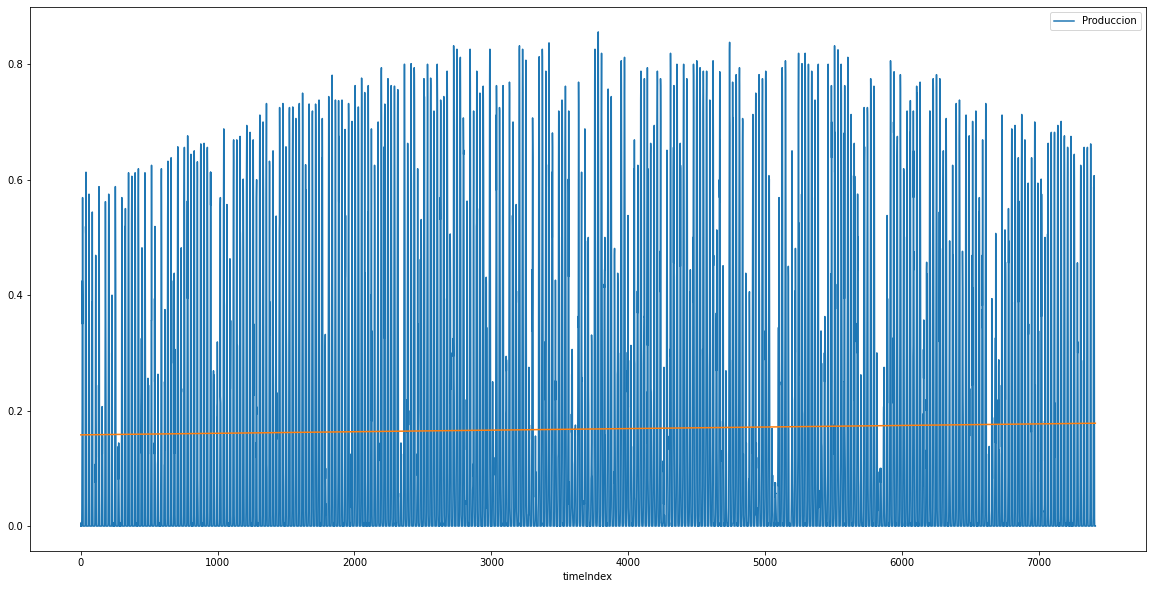

In [79]:
model_linear_pred = model_linear.predict()
df_train["ProduccionLinear"] = model_linear_pred
df_test["ProduccionLinear"] = model_linear.predict(df_test.timeIndex)
df_train.plot(kind="line", x="timeIndex", y = "Produccion", figsize=(20,10))
plt.plot(df_train.timeIndex,model_linear_pred, '-')

In [80]:
put_model_result(
    "Regresion Lineal", 
    RMSE(df_train.ProduccionLinear, df_train.Produccion),
    RMSE(df_test.ProduccionLinear, df_test.Produccion)
  )

,Model,RMSE Train,RMSE Test
0,Media constante,0.243035,0.18775
1,Regresion Lineal,0.242966,0.19246


## Linear + Variables endogenas

In [81]:
# Ahora estimamos una variante del modelo lineal, incluyendo las variables endogenas
model_linear_endogenas = smf.ols('Produccion ~ timeIndex + Viento + Humedad + Presion_atmosferica + Visibilidad + Clear  + Partly_sunny + Passing_clouds + Scattered_clouds + Sunny + Hora + Mes', data = df_train).fit()
model_linear_endogenas.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Produccion   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     556.4
Date:                Thu, 23 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:20:09   Log-Likelihood:                 2201.6
No. Observations:                7416   AIC:                            -4379.
Df Residuals:                    7404   BIC:                            -4296.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.1898      0.329     -3.611      0.000      -1.836      -0.544
timeIndex            1.253e-05   1.24e-06     10.097      0.000    1.01e-05     1.5e-05
Viento                  0.0025      0.000     11.154      0.000       0.002       0.003
Humedad                -0.0067      0.000    -43.899      0.000      -0.007      -0.006
Presion_atmosferica     0.0019      0.000      4.973      0.000       0.001       0.003
Visibilidad             0.0004      0.001      0.637      0.524      -0.001       0.002
Clear                  -0.4033      0.065     -6.162      0.000      -0.532      -0.275
Partly_sunny           -0.2059      0.066     -3.110      0.002      -0.336      -0.076
Passing_clouds         -0.2738      0.067     -4.114      0.000      -0.404      -0.143
Scattered_clouds       -0.1339      0.067     -1.998      0.046      -0.265      -0.003
Sunny                  -0.1728      0.065     -2.650      0.008      -0.301      -0.045
Hora                   -0.0003      0.000     -0.877      0.381      -0.001       0.000
Mes                     0.0005      0.001      0.719      0.472      -0.001       0.002
==============================================================================
Omnibus:                      665.795   Durbin-Watson:                   0.355
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              886.226
Skew:                           0.759   Prob(JB):                    3.62e-193
Kurtosis:                       3.752   Cond. No.                     6.92e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.96e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [82]:
df_train["ProduccionLinearEndogenas"] = model_linear_endogenas.predict(df_train[['timeIndex', 'Viento', 'Humedad', 'Presion_atmosferica', 'Visibilidad', 'Clear', 'Partly_sunny', 'Passing_clouds', 'Scattered_clouds', 'Sunny', 'Hora', 'Mes']])
df_test["ProduccionLinearEndogenas"] = model_linear_endogenas.predict(df_test[['timeIndex', 'Viento', 'Humedad', 'Presion_atmosferica', 'Visibilidad', 'Clear', 'Partly_sunny', 'Passing_clouds', 'Scattered_clouds', 'Sunny', 'Hora', 'Mes']])
df_train.ProduccionLinearEndogenas = df_train.ProduccionLinearEndogenas.apply(lambda x: x if x>0 else 0)
model_linear_endogenas.params

Intercept             -1.189763
timeIndex              0.000013
Viento                 0.002513
Humedad               -0.006700
Presion_atmosferica    0.001914
Visibilidad            0.000440
Clear                 -0.403312
Partly_sunny          -0.205947
Passing_clouds        -0.273815
Scattered_clouds      -0.133857
Sunny                 -0.172832
Hora                  -0.000280
Mes                    0.000491
dtype: float64

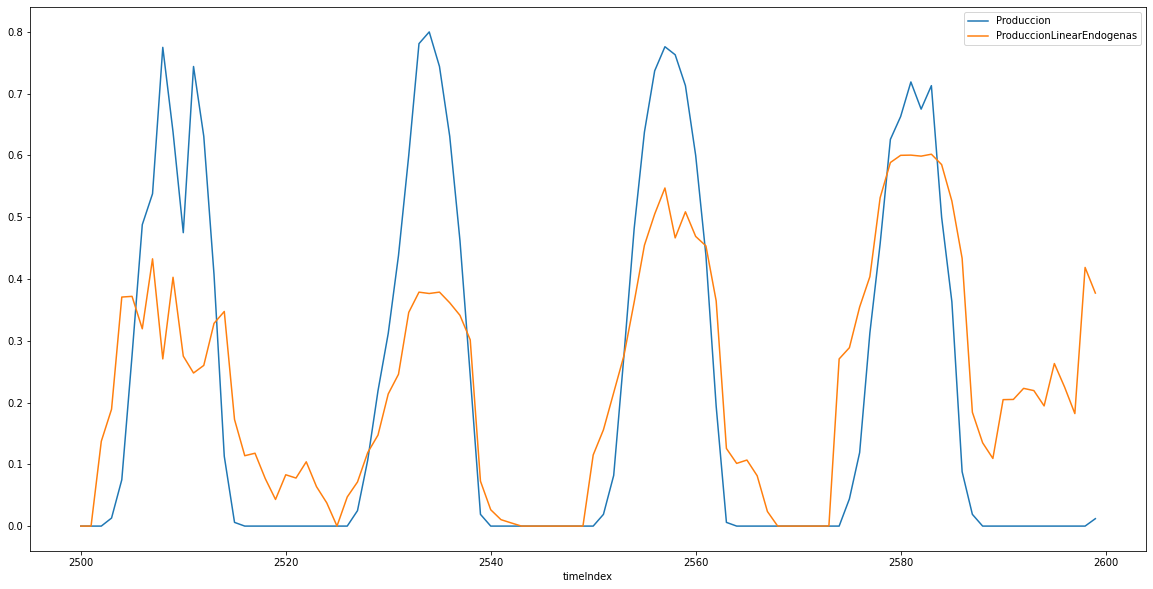

In [83]:
df_train[2500:2600].plot(kind="line", x="timeIndex", y = ["Produccion", "ProduccionLinearEndogenas"], figsize=(20,10));

In [84]:
put_model_result(
    "Regresion Lineal + Endogenas", 
    RMSE(df_train.ProduccionLinearEndogenas, df_train.Produccion),
    RMSE(df_test.ProduccionLinearEndogenas, df_test.Produccion)
  )

,Model,RMSE Train,RMSE Test
0,Media constante,0.243035,0.18775
1,Regresion Lineal,0.242966,0.19246
2,Regresion Lineal + Endogenas,0.176442,0.156036


## Media Movil - SMA (Simple Moving Averange)

In [85]:
def predict_n_periods_sma(data, n_periods, window_size):
  last = data.rolling(window = window_size).mean().apply(lambda x: x if x>0 else 0)[-1:].values[0]
  predicts = []
  predicts.append(last)
  for i in range(n_periods - 1):
    ultimos = pd.DataFrame(data[-window_size:].tolist() + predicts).tail(window_size)
    last = ultimos.rolling(window = window_size).mean().apply(lambda x: x if pd.isnull(x.iloc[0]) or x>0 else 0)[-1:].values[0][0]
    predicts.append(last)

  return predicts

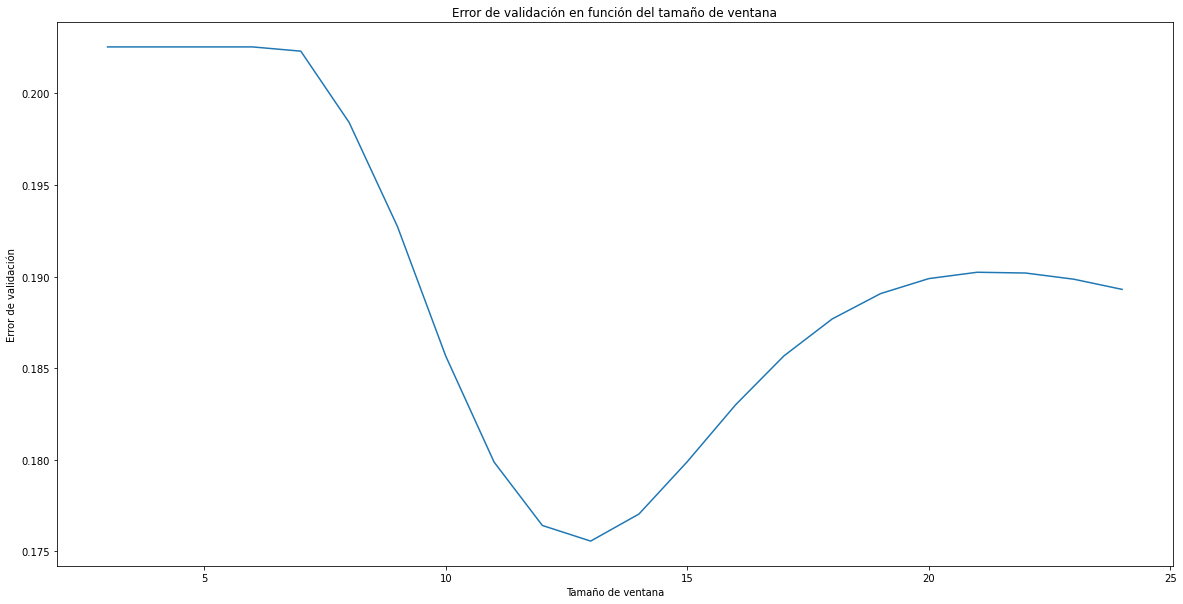

El mejor tamaño de ventana es: 13


In [86]:
window_sizes = range(3, 25)
ls_scores = []
for window_size in window_sizes:
    predicciones =  predict_n_periods_sma(df_train.Produccion, df_test.shape[0], window_size)
    score = RMSE(predicciones, df_test.Produccion)
    ls_scores.append(score)

best_window_size = window_sizes[np.argmin(ls_scores)]

plt.figure(figsize=(20, 10))
plt.plot(window_sizes, ls_scores)
plt.title('Error de validación en función del tamaño de ventana')
plt.xlabel('Tamaño de ventana')
plt.ylabel('Error de validación')
plt.show()

print(f"El mejor tamaño de ventana es: {best_window_size}")

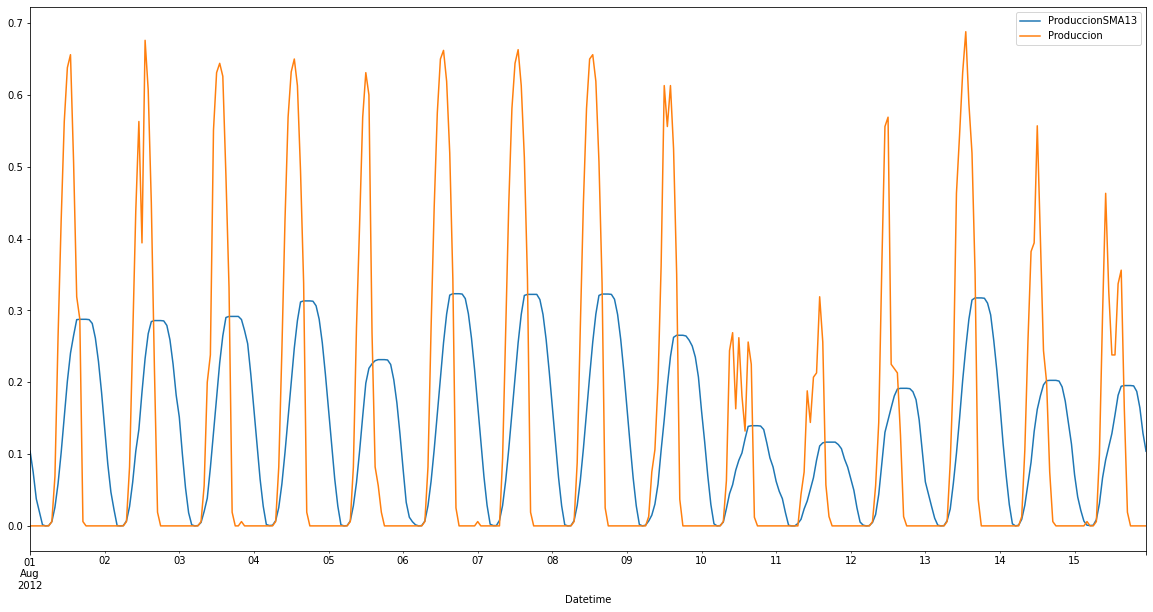

In [87]:
df_train['ProduccionSMA13'] = df_train.Produccion.rolling(window = 13).mean().shift(-1).apply(lambda x: x if x>0 else 0)
df_train.loc['2012-08-01 00:00:00':'2012-08-15 23:30:00'].plot(kind ="line", y=["ProduccionSMA13", "Produccion"], figsize=(20,10));


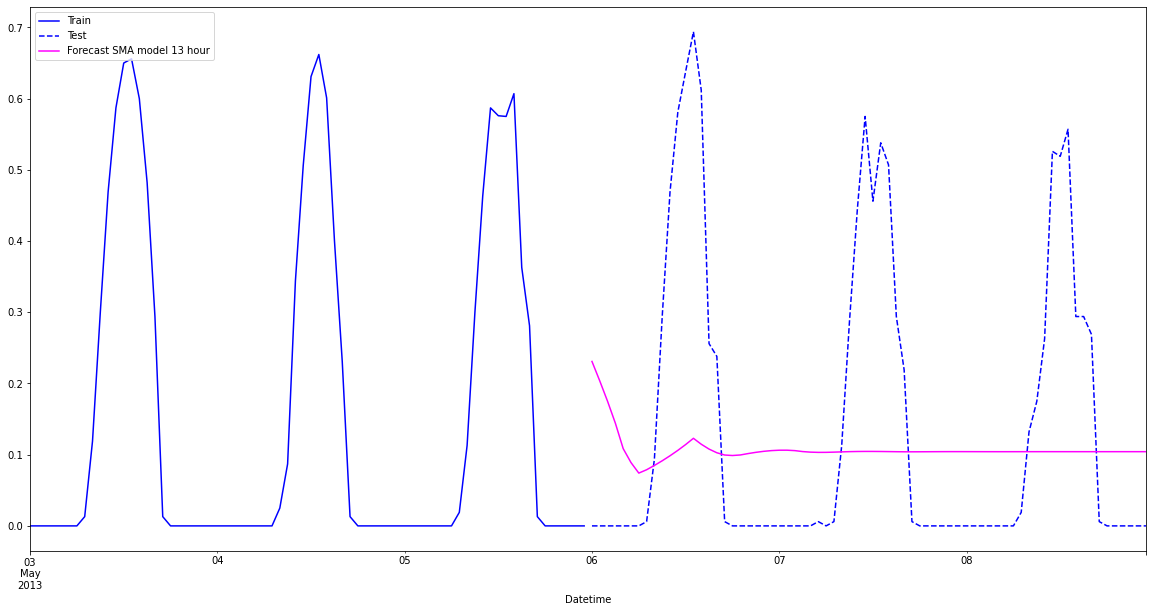

In [88]:
periodos = 24 * 3 
df_train['Produccion'][-periodos:].plot(figsize=(20,10), label='Train', color='blue')
df_test['Produccion'][0:periodos].plot(label='Test', color='blue', style= '--')
df_test['ProduccionSMA13'] = predict_n_periods_sma(df_train.Produccion, df_test.shape[0], 13)
df_test.ProduccionSMA13[0:periodos].plot(label='Forecast SMA model 13 hour', color= 'magenta')
plt.legend(loc='upper left')

In [89]:
put_model_result(
    "Media Movil", 
    RMSE(df_train.ProduccionSMA13, df_train.Produccion),
    RMSE(df_test.ProduccionSMA13, df_test.Produccion),
  )

,Model,RMSE Train,RMSE Test
0,Media constante,0.243035,0.18775
1,Regresion Lineal,0.242966,0.19246
2,Regresion Lineal + Endogenas,0.176442,0.156036
3,Media Movil,0.235675,0.175562


## Media movil exponencial - EWMA (exponentially weighted moving average)

In [90]:
def predict_n_periods_ewma(data, n_periods, window_size):
  last = data.ewm(span = window_size, adjust=False).mean().apply(lambda x: x if x>0 else 0)[-1:].values[0]
  predicts = []
  predicts.append(last)
  for i in range(n_periods - 1):
    ultimos = pd.DataFrame(data[-window_size:].tolist() + predicts).tail(window_size)
    last = ultimos.ewm(span=window_size, adjust=False).mean().applymap(lambda x: x if x > 0 else 0 if pd.notnull(x) else np.nan)[-1:].values[0][0]
    predicts.append(last)

  return predicts

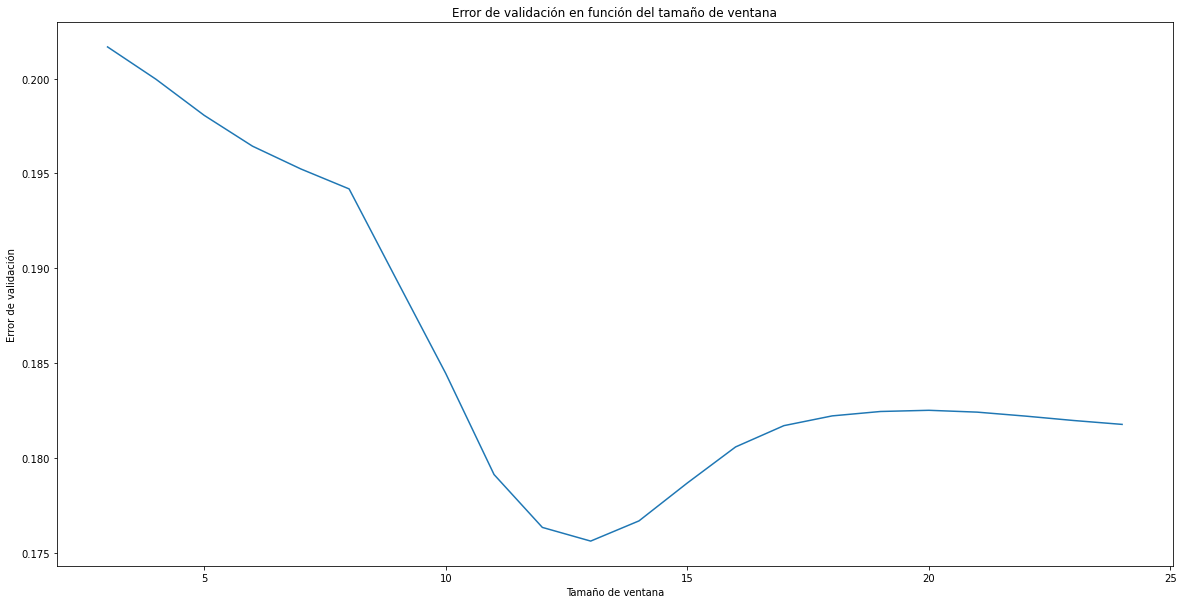

El mejor tamaño de ventana es: 13


In [91]:
window_sizes = range(3, 25)
ls_scores = []
n_predicts = df_test.shape[0]
for window_size in window_sizes:
    predicciones =  predict_n_periods_ewma(df_train.Produccion, n_predicts, window_size)
    score = RMSE(predicciones, df_test.Produccion)
    ls_scores.append(score)

best_window_size = window_sizes[np.argmin(ls_scores)]

plt.figure(figsize=(20, 10))
plt.plot(window_sizes, ls_scores)
plt.title('Error de validación en función del tamaño de ventana')
plt.xlabel('Tamaño de ventana')
plt.ylabel('Error de validación')
plt.show()

print(f"El mejor tamaño de ventana es: {best_window_size}")

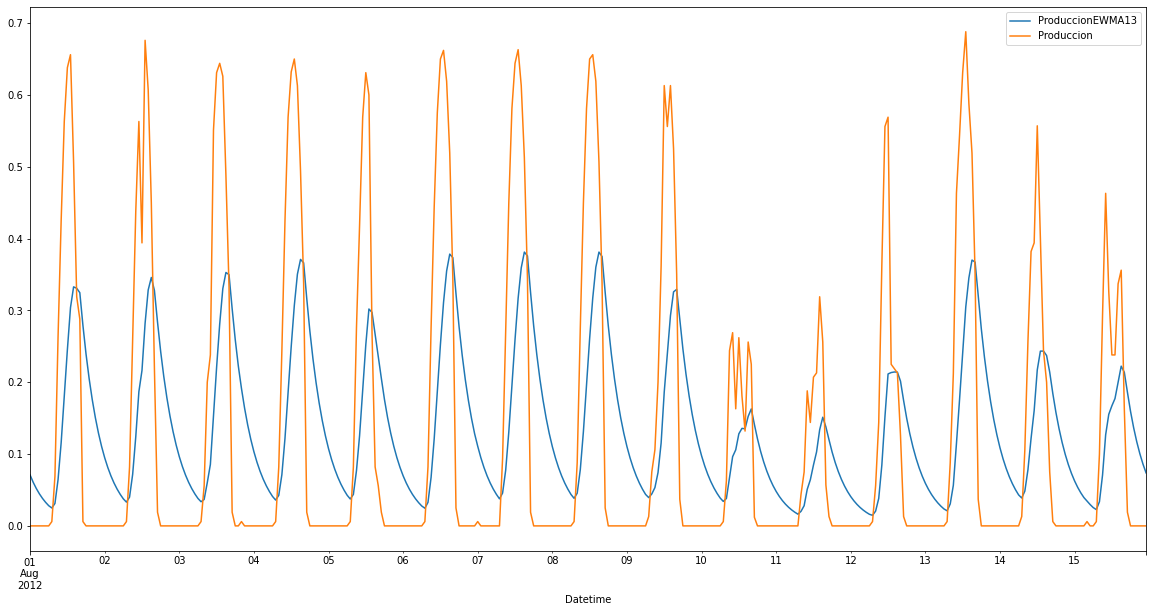

In [92]:
df_train['ProduccionEWMA13'] = df_train.Produccion.ewm(span = 13, adjust=False).mean().apply(lambda x: x if x>0 else 0)
df_train.loc['2012-08-01 00:00:00':'2012-08-15 23:30:00'].plot(kind ="line", y=["ProduccionEWMA13", "Produccion"], figsize=(20,10));

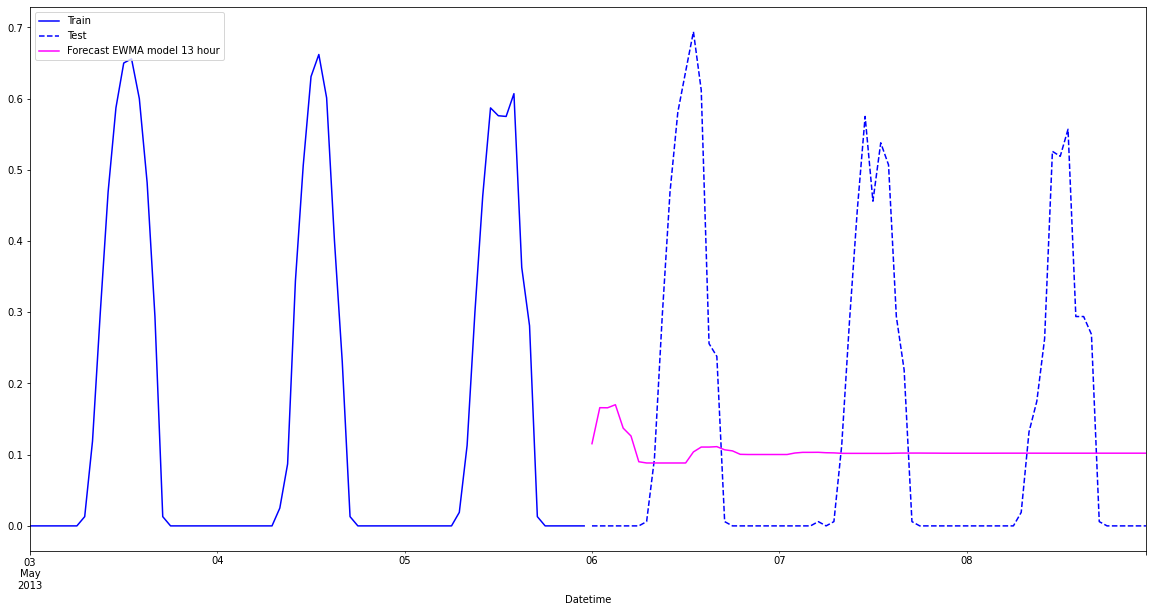

In [93]:
periodos = 24 * 3 
df_train['Produccion'][-periodos:].plot(figsize=(20,10), label='Train', color='blue')
df_test['Produccion'][0:periodos].plot(label='Test', color='blue', style= '--')
df_test['ProduccionEWMA13'] = predict_n_periods_ewma(df_train.Produccion, df_test.shape[0], 13)
df_test.ProduccionEWMA13[0:periodos].plot(label='Forecast EWMA model 13 hour', color= 'magenta')
plt.legend(loc='upper left')


In [94]:
put_model_result(
    "Media Movil Exponencial", 
    RMSE(df_train.ProduccionEWMA13, df_train.Produccion),
    RMSE(df_test.ProduccionEWMA13, df_test.Produccion)
  )

,Model,RMSE Train,RMSE Test
0,Media constante,0.243035,0.18775
1,Regresion Lineal,0.242966,0.19246
2,Regresion Lineal + Endogenas,0.176442,0.156036
3,Media Movil,0.235675,0.175562
4,Media Movil Exponencial,0.194592,0.17563


## Suavisado exponencial doble (DES - Double Exponential Smoothing)

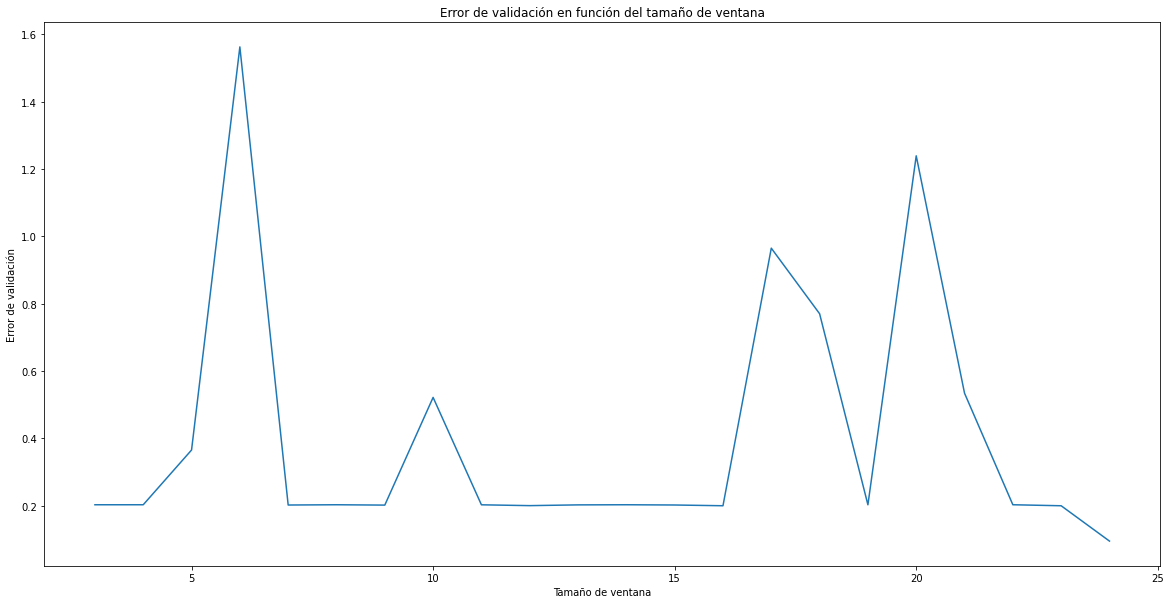

El mejor tamaño de ventana es: 24


In [95]:
window_sizes = range(3, 25)
ls_scores = []
n_predicts = df_test.shape[0]

for window_size in window_sizes:
    modelDES = ExponentialSmoothing(df_train['Produccion'], trend='add', seasonal='add', seasonal_periods=window_size).fit()
    predicciones =  modelDES.forecast(n_predicts).apply(lambda x: x if x>0 else 0)
    score = RMSE(predicciones, df_test.Produccion)
    ls_scores.append(score)

best_window_size = window_sizes[np.argmin(ls_scores)]

plt.figure(figsize=(20, 10))
plt.plot(window_sizes, ls_scores)
plt.title('Error de validación en función del tamaño de ventana')
plt.xlabel('Tamaño de ventana')
plt.ylabel('Error de validación')
plt.show()

print(f"El mejor tamaño de ventana es: {best_window_size}")

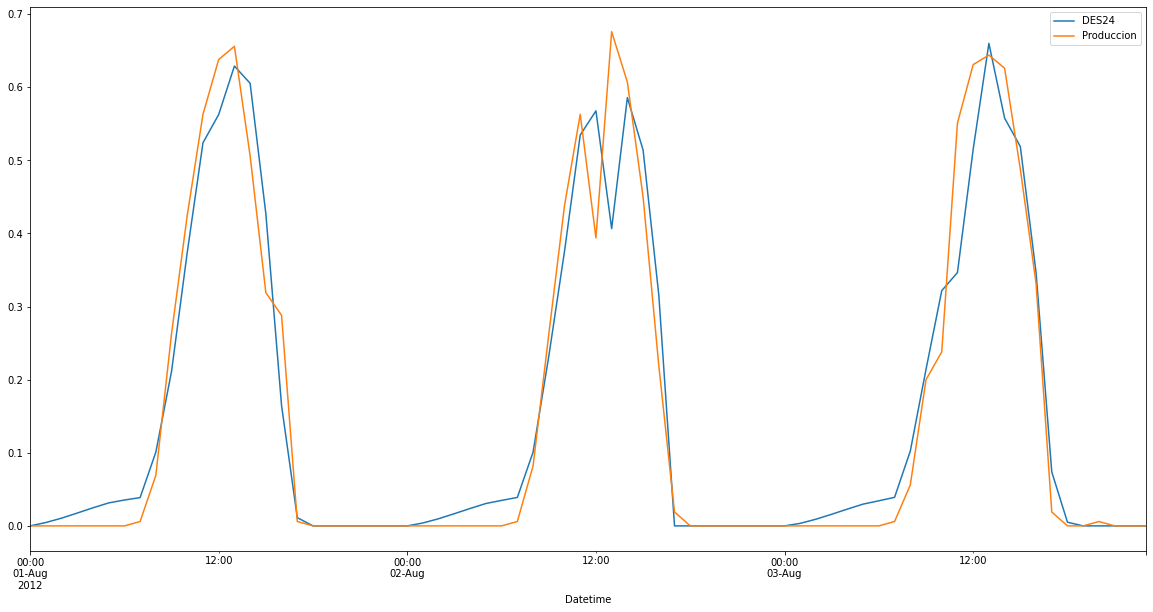

In [96]:
modelDES24 = ExponentialSmoothing(df_train['Produccion'], trend='add', seasonal='add', seasonal_periods=24).fit()
df_train['DES24'] = modelDES24.fittedvalues.apply(lambda x: x if x>0 else 0)
df_train.loc['2012-08-01 00:00:00':'2012-08-03 23:30:00'].plot(kind='line', y=["DES24", "Produccion"], figsize=(20,10))

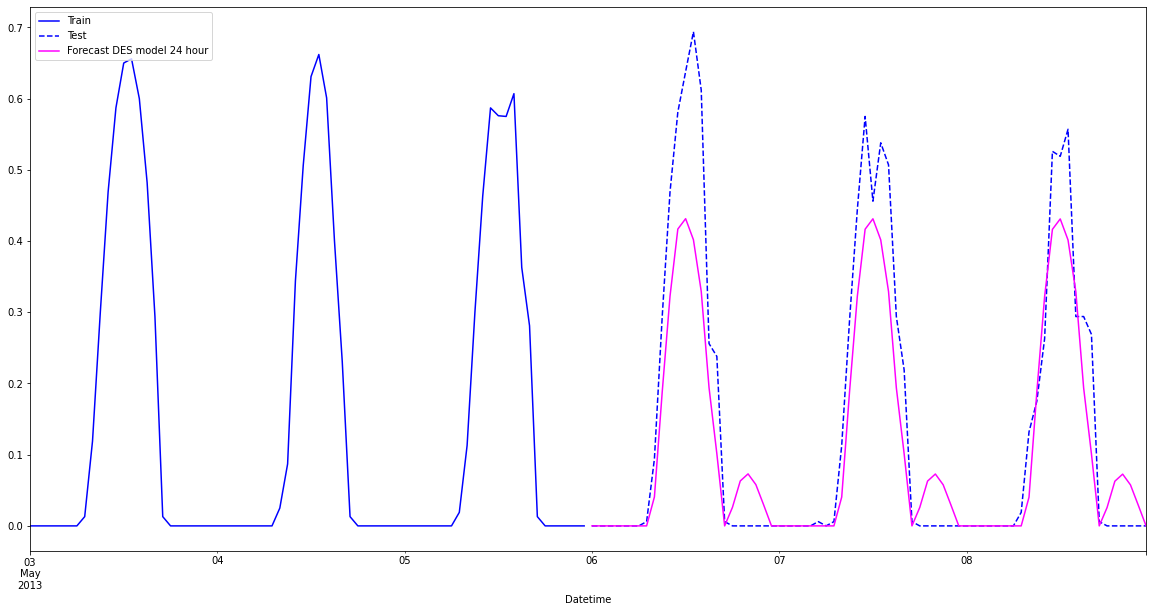

In [97]:
periodos = 24 * 3 
forecast_des_24 =  modelDES24.forecast(periodos).apply(lambda x: x if x>0 else 0)
df_train['Produccion'][-periodos:].plot(figsize=(20,10), label='Train', color='blue')
df_test['Produccion'][0:periodos].plot(label='Test', color='blue', style= '--')
forecast_des_24.plot(label='Forecast DES model 24 hour', color= 'magenta')
plt.legend(loc='upper left')


In [98]:
periodos = df_test.shape[0]
forecast_des_24 =  modelDES24.forecast(periodos).apply(lambda x: x if x>0 else 0)
df_test['DES24'] = forecast_des_24
put_model_result(
    "Suavisado exponencial doble", 
    RMSE(df_train.DES24, df_train.Produccion),
    RMSE(df_test.DES24, df_test.Produccion),
  )

,Model,RMSE Train,RMSE Test
0,Media constante,0.243035,0.18775
1,Regresion Lineal,0.242966,0.19246
2,Regresion Lineal + Endogenas,0.176442,0.156036
3,Media Movil,0.235675,0.175562
4,Media Movil Exponencial,0.194592,0.17563
5,Suavisado exponencial doble,0.071647,0.094529


## ARIMA

### autoarima --> SARIMAX(3, 0, 1) AIC=-15424.307

In [473]:
step_wise=auto_arima(df_train.Produccion, 
  start_p=1, start_q=1, 
  max_p=24, max_q=24, 
  d=0, max_d=0,
  trace=True, 
  error_action='ignore', 
  suppress_warnings=True, 
  stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-14672.699, Time=5.47 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=69.099, Time=0.75 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-13172.683, Time=0.58 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-7352.734, Time=2.44 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2966.586, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-16103.438, Time=9.35 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-15550.124, Time=2.13 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-16238.834, Time=25.21 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-15897.280, Time=3.23 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-16085.452, Time=19.59 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-16226.129, Time=27.61 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-16041.322, Time=16.50 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-16045.850, Time=1.67 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-16189.597, Time=21.23 sec
 ARIMA(

In [475]:
step_wise.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7416
Model:               SARIMAX(3, 0, 1)   Log Likelihood                8125.417
Date:                Thu, 23 Feb 2023   AIC                         -16238.834
Time:                        07:20:33   BIC                         -16197.366
Sample:                    07-01-2012   HQIC                        -16224.586
                         - 05-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0098      0.001     12.666      0.000       0.008       0.011
ar.L1          2.0421      0.021     98.093      0.000       2.001       2.083
ar.L2         -1.3075      0.031    -42.153      0.000      -1.368      -1.247
ar.L3          0.2073      0.014     14.833      0.000       0.180       0.235
ma.L1         -0.8229      0.020    -42.053      0.000      -0.861      -0.785
sigma2         0.0065   6.96e-05     94.043      0.000       0.006       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):             10803.63
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
sarimax_3_0_1_0_0_0_0 = SARIMAX(df_train.Produccion, order=(3,0,1), seasonal_order=(0, 0, 0, 0)).fit()
print(sarimax_3_0_1_0_0_0_0.summary())

                               SARIMAX Results                                
Dep. Variable:             Produccion   No. Observations:                 7416
Model:               SARIMAX(3, 0, 1)   Log Likelihood                7717.154
Date:                Thu, 23 Feb 2023   AIC                         -15424.307
Time:                        16:54:51   BIC                         -15389.750
Sample:                    07-01-2012   HQIC                        -15412.434
                         - 05-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5672      0.057     27.336      0.000       1.455       1.680
ar.L2         -0.6046      0.080     -7.545      0.000      -0.762      -0.448
ar.L3         -0.0452      0.028     -1.600      0.1

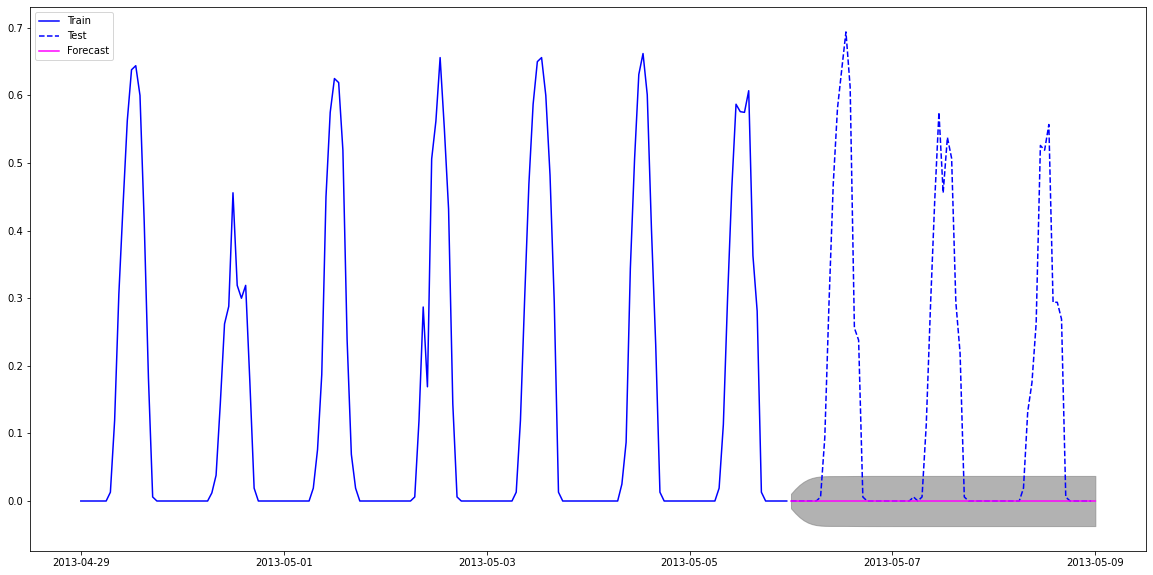

In [59]:
predict_plot(sarimax_3_0_1_0_0_0_0, df_train, df_test, 24*7, 24 * 3)

In [60]:
def plot_fit(model, column_name, date_from, date_to):
  df_train[column_name] = model.fittedvalues.shift(-1).apply(lambda x: x if x>0 else 0)
  df_train.Produccion.loc[date_from:date_to].plot(figsize=(20,10))
  df_train[column_name].loc[date_from:date_to].plot()

def plot_forecast(model, periods, dftrain, dftest):
  forecast_results =  model.forecast(periods).apply(lambda x: x if x>0 else 0)

  dftrain['Produccion'][-periods:].plot(figsize=(20,10), label='Train', color='blue')
  #df_train['DES'][-48*7:].plot(figsize=(20,10), label='prod fit', color='green')
  dftest['Produccion'][:periods].plot(label='Test', color='blue', style= '--')
  forecast_results.plot(label='Forecast', color= 'magenta')
  plt.legend(loc='upper left')

def plot_forecast_exog(model, periods, columns_exogenus, dftrain, dftest):
  forecast_results =  model.forecast(periods, exog = dftest[columns_exogenus][:periods]).apply(lambda x: x if x>0 else 0)

  dftrain['Produccion'][-periods:].plot(figsize=(20,10), label='Train', color='blue')
  #df_train['DES'][-48*7:].plot(figsize=(20,10), label='prod fit', color='green')
  dftest['Produccion'][:periods].plot(label='Test', color='blue', style= '--')
  forecast_results.plot(label='Forecast', color= 'magenta')
  plt.legend(loc='upper left')
    

### SARIMAX (3,0,1)(2,0,2,24) --> AIC -17695.509


In [62]:
columns_exog = ['Temperatura', 'Viento', 'Humedad',
       'Presion_atmosferica', 'Visibilidad', 'Clear', 'Partly_sunny',
       'Passing_clouds', 'Scattered_clouds', 'Sunny']

sarimax_3_0_1_2_0_2_24 = SARIMAX(df_train.Produccion, exog = df_train[columns_exog], order=(3,0,1), seasonal_order=(2, 0, 2, 24)).fit()
print(sarimax_3_0_1_2_0_2_24.summary())

                                        SARIMAX Results                                        
Dep. Variable:                              Produccion   No. Observations:                 7416
Model:             SARIMAX(3, 0, 1)x(2, 0, [1, 2], 24)   Log Likelihood                8866.755
Date:                                 Thu, 23 Feb 2023   AIC                         -17695.509
Time:                                         17:07:47   BIC                         -17564.193
Sample:                                     07-01-2012   HQIC                        -17650.391
                                          - 05-05-2013                                         
Covariance Type:                                   opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Temperatura             0.0158      0.001     16.777    

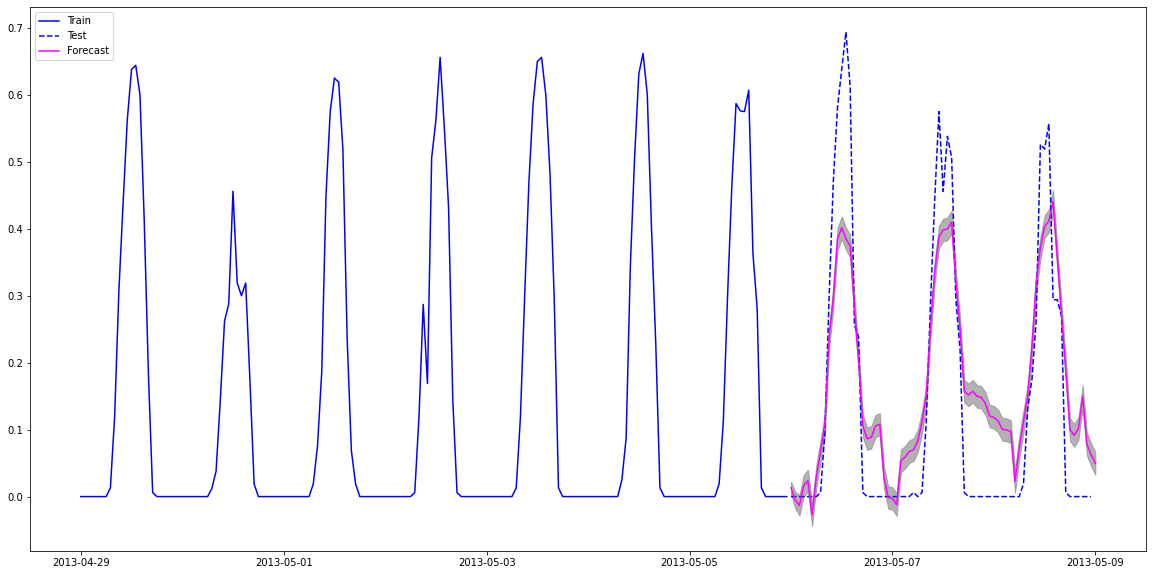

In [63]:
predict_plot(sarimax_3_0_1_2_0_2_24, df_train, df_test, 24*7, 24 * 3, columns_exog)

In [64]:
def get_rmse_sarimax(model, df):
  date_from = df.reset_index()["Datetime"].min()
  date_to = df.reset_index()["Datetime"].max()

  predicted = model.get_prediction(start=date_from, end=date_to, dynamic=False, exog=df.loc[date_from:date_to][columns_exog])
  actual = df.loc[date_from:date_to].Produccion

  mse = (predicted.predicted_mean - actual)**2
  rmse = np.sqrt(mse.sum()/mse.count())
  return rmse    

In [99]:
put_model_result(
    "SARIMAX (3,0,1)(2,0,2,24)", 
    get_rmse_sarimax(sarimax_3_0_1_2_0_2_24, df_train),
    get_rmse_sarimax(sarimax_3_0_1_2_0_2_24, df_test)
  )


,Model,RMSE Train,RMSE Test
0,Media constante,0.243035,0.18775
1,Regresion Lineal,0.242966,0.19246
2,Regresion Lineal + Endogenas,0.176442,0.156036
3,Media Movil,0.235675,0.175562
4,Media Movil Exponencial,0.194592,0.17563
5,Suavisado exponencial doble,0.071647,0.094529
6,"SARIMAX (3,0,1)(2,0,2,24)",0.073192,0.136001


## LSTM

In [66]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

In [67]:
# convertimos un array de valores en una matriz de conjuntos de datos
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return numpy.array(dataX), numpy.array(dataY)

In [68]:
# semilla aleatoria para reproducibilidad
numpy.random.seed(7)

dataset = df_join['Produccion']

# dividimos entre entrenamiento y test
train = df_train_24.Produccion.values.reshape(-1, 1)
test = df_test_24.Produccion.values.reshape(-1, 1)
validation = df_validation_24.Produccion.values.reshape(-1, 1)


# normalizamos el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
test = scaler.fit_transform(test)
validation = scaler.fit_transform(validation)

# remodelamos X=t y Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
validationX, validationY = create_dataset(validation, look_back)

# # remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
# trainX = trainX.reshape(trainX.shape[0], look_back, -1)
# testX = testX.reshape(testX.shape[0], look_back, -1)
# validationX = validationX.reshape(validationX.shape[0], look_back, -1)


In [ ]:
# file_name = '/content/drive/My Drive/solar_panel_models/scaler.pkl'
# pickle.dump(scaler, open(file_name, 'wb'))

In [ ]:
#creamos la LSTM network
model = Sequential()
model.add(LSTM(6, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

In [ ]:
# remodelamos X=t y Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
validationX, validationY = create_dataset(validation, look_back)

# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
trainX = trainX.reshape(trainX.shape[0], look_back, -1)
testX = testX.reshape(testX.shape[0], look_back, -1)
validationX = validationX.reshape(validationX.shape[0], look_back, -1)

# Función para crear modelo de red LSTM
def create_model(num_layers, num_units):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(LSTM(num_units, input_shape=(look_back, 1), return_sequences=True))
        elif i == num_layers - 1:
            model.add(LSTM(num_units))
        else:
            model.add(LSTM(num_units, return_sequences=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Crear modelo envuelto en KerasRegressor para su uso en GridSearchCV
model = KerasRegressor(build_fn=create_model, verbose=0)

# Definir valores para los hiperparámetros
num_layers = [1, 2]
num_units = [4, 8]
batch_size = [1, 2]
epochs = [5, 10]

# Crear diccionario de parámetros a ser explorados
param_grid = dict(num_layers=num_layers, num_units=num_units, batch_size=batch_size, epochs=epochs)

# Realizar búsqueda de cuadrícula
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(trainX, trainY)

# Imprimir resultados
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# <ipython-input-117-b29631b553fb>:33: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
#   model = KerasRegressor(build_fn=create_model, verbose=0)
# /usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
#   warnings.warn(
# Best: -0.007593 using {'batch_size': 2, 'epochs': 10, 'num_layers': 2, 'num_units': 8}

In [71]:
#creamos la LSTM network
model = Sequential()
model.add(LSTM(8, input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(8))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=2, verbose=2)

Epoch 1/10
3705/3705 - 31s - loss: 0.0241 - 31s/epoch - 8ms/step
Epoch 2/10
3705/3705 - 18s - loss: 0.0090 - 18s/epoch - 5ms/step
Epoch 3/10
3705/3705 - 19s - loss: 0.0082 - 19s/epoch - 5ms/step
Epoch 4/10
3705/3705 - 18s - loss: 0.0077 - 18s/epoch - 5ms/step
Epoch 5/10
3705/3705 - 20s - loss: 0.0074 - 20s/epoch - 5ms/step
Epoch 6/10
3705/3705 - 19s - loss: 0.0071 - 19s/epoch - 5ms/step
Epoch 7/10
3705/3705 - 21s - loss: 0.0071 - 21s/epoch - 6ms/step
Epoch 8/10
3705/3705 - 28s - loss: 0.0070 - 28s/epoch - 8ms/step
Epoch 9/10
3705/3705 - 20s - loss: 0.0070 - 20s/epoch - 5ms/step
Epoch 10/10
3705/3705 - 18s - loss: 0.0069 - 18s/epoch - 5ms/step


In [72]:
# hacemos las predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
validationPredict = model.predict(validationX)

# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
validationPredict = scaler.inverse_transform(validationPredict)
validationY = scaler.inverse_transform([validationY])

# calculamos el error rms
rmse_train = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Resultado del entrenamiento: %.2f RMSE' % (rmse_train))
rmse_test = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Resultado del test: %.2f RMSE' % (rmse_test))
rmse_validation = math.sqrt(mean_squared_error(validationY[0], validationPredict[:,0]))
print('Resultado del validation: %.2f RMSE' % (rmse_validation))

# 232/232 [==============================] - 2s 4ms/step
# 21/21 [==============================] - 0s 4ms/step
# 21/21 [==============================] - 0s 3ms/step
# Resultado del entrenamiento: 0.05 RMSE
# Resultado del test: 0.05 RMSE
# Resultado del validation: 0.06 RMSE

21/21 [==============================] - 0s 2ms/step
Resultado del entrenamiento: 0.05 RMSE
Resultado del test: 0.05 RMSE
Resultado del validation: 0.06 RMSE


In [100]:
put_model_result(
    "LSTM", 
    rmse_train,
    rmse_test,
  )


,Model,RMSE Train,RMSE Test
0,Media constante,0.243035,0.18775
1,Regresion Lineal,0.242966,0.19246
2,Regresion Lineal + Endogenas,0.176442,0.156036
3,Media Movil,0.235675,0.175562
4,Media Movil Exponencial,0.194592,0.17563
5,Suavisado exponencial doble,0.071647,0.094529
6,"SARIMAX (3,0,1)(2,0,2,24)",0.073192,0.136001
7,LSTM,0.048004,0.049235
